## Current RoadMap
### Week 6: Advanced Pandas with data cleaning.
* Loading data and cleaning
* Filerting, grouping and plotting data

### Week 7: Pulling it all together 
* json through pandas through plotting through saving updated data

# 1. Load in data + check the data
Let's start by loading in and checking the cleanliness of dataset from Hestia...

In [1]:
# Load in the libraries we require for today
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


Let's use pandas to load in Excel data
If this does not work, use: !pip install openpyxl


In [2]:
!pip install openpyxl


In [3]:
# Load Maize data from Hestia 
df = pd.read_excel("MaizePig.xlsx")  


In [4]:
# Look at the data
df.head()


,General info,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,...,Unnamed: 255,Unnamed: 256,Unnamed: 257,Unnamed: 258,Unnamed: 259,Unnamed: 260,Unnamed: 261,Unnamed: 262,Unnamed: 263,Unnamed: 264
0,HH_ID,-,-,-,-,-,-,-,-,-,...,Total person days of family labor,-,-,-,-,-,-,-,-,-
1,site.id,cycle.id,cycle.site.id,cycle.description,cycle.cycleDuration,cycle.defaultMethodClassification,cycle.defaultMethodClassificationDescription,source.id,source.uploadNotes,source.bibliography.title,...,-,cycle.practices.6.term.name,cycle.practices.6.value,cycle.practices.6.cost,cycle.practices.6.price,cycle.practices.6.currency,cycle.practices.7.term.name,cycle.practices.7.value,cycle.practices.8.term.name,cycle.practices.8.value
2,1008,1008,1008,"Maize-Pigeon pea, seed (whole) intercropping s...",365,non-verified survey data,Survey with farmers,1,When no information on irrigation was provided...,"Shan Household, Agriculture and Rural Economy:...",...,41.5,-,-,-,-,-,Family labour,273.457333,Residue removed,0
3,1016,1016,1016,"Maize-Pigeon pea, seed (whole) intercropping s...",365,non-verified survey data,Survey with farmers,1,When no information on irrigation was provided...,"Shan Household, Agriculture and Rural Economy:...",...,49.25,Hired labour,23.4745,11737.25,500.0,MMK,Family labour,486.787,Residue removed,0
4,1023,1023,1023,"Maize-Pigeon pea, seed (whole) intercropping s...",365,non-verified survey data,Survey with farmers,1,When no information on irrigation was provided...,"Shan Household, Agriculture and Rural Economy:...",...,49.3125,Hired labour,699.52132,393003.03665,561.817096,MMK,Family labour,243.702375,Residue removed,0


Hmm, the data looks a little messy (265 columns is quite a lot!) and the column names are not lined up correctly. Obviously, we may just go into Excel and fix this manually, but I will also show you how to clean this using Python directly. 

#### 🤨 TASK
We've looked at the header, and can see there is clearly problems. In the cell below look at the footer of the data to see if there is any other obvious issues.


Next, let's look at some summary statistics of the data, this will give us some indication about missing data and data types

In [5]:
df.describe()
# df.info()


,General info,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,...,Unnamed: 255,Unnamed: 256,Unnamed: 257,Unnamed: 258,Unnamed: 259,Unnamed: 260,Unnamed: 261,Unnamed: 262,Unnamed: 263,Unnamed: 264
count,931,931,931,931,931,931,931,931,931,931,...,931,931,931,931,931,931,931,931,931,931
unique,931,931,931,5,3,3,3,3,3,3,...,424,3,416,498,375,3,3,593,3,3
top,HH_ID,-,-,"Maize-Pigeon pea, seed (whole) intercropping s...",365,non-verified survey data,Survey with farmers,1,When no information on irrigation was provided...,"Shan Household, Agriculture and Rural Economy:...",...,15,Hired labour,-,-,-,MMK,Family labour,-,Residue removed,0
freq,1,1,1,431,929,929,929,929,929,929,...,16,612,318,318,318,612,919,11,929,929


Clearly the column names are being put as a seperate row, this is a common issue with Excel sheets from different sources. Before working with this data we need to fix this

# 2. Cleaning data in python 
From first look (and some investigation in Excel), it looks like we need to combine the first two rows ~, and maybk if we need to change some of the data types, for example strings to integers.
 

Open in excel to view problems and get an idea of what cleaning needs to be done. First row has useful information.

First look at the columns

In [6]:
df.columns.unique()


Index(['General info', 'Unnamed: 1', 'Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4',
       'Unnamed: 5', 'Unnamed: 6', 'Unnamed: 7', 'Unnamed: 8', 'Unnamed: 9',
       ...
       'Unnamed: 255', 'Unnamed: 256', 'Unnamed: 257', 'Unnamed: 258',
       'Unnamed: 259', 'Unnamed: 260', 'Unnamed: 261', 'Unnamed: 262',
       'Unnamed: 263', 'Unnamed: 264'],
      dtype='object', length=265)

Hmm, let's look at the columns without these Unnamed columns.   ~
We can achieve this reduced view with list comprehension and ask the list not to include the term 'Unnamed'

In [7]:
[col_name for col_name in list(df.columns.unique()) if 'Unnamed' not in col_name]


['General info',
 'Parcel',
 'by crop',
 'by crop.1',
 'by crop.2',
 'by crop.3',
 'by crop.4',
 'by crop.5',
 'by crop.6',
 'Parcel.1',
 'Parcel.2',
 'Parcel.3',
 'Parcel.4',
 'Parcel.5',
 'Parcel.6',
 'Parcel.7',
 'Parcel.8',
 'Parcel.9',
 'Parcel.10',
 'Parcel.11',
 'Parcel.12',
 'Parcel.13',
 'Parcel.14',
 'Parcel.15',
 'Parcel.16',
 'Parcel.17',
 'Parcel.18',
 'Parcel.19',
 'By machine',
 'By machine.1',
 'By machine.2',
 'By machine.3',
 'By machine.4',
 'By machine.5',
 'By machine.6',
 'By machine.7',
 'By machine.8',
 'By machine.9',
 'By machine.10',
 'By machine.11',
 'Parcel.20',
 'Parcel.21',
 'Parcel.22',
 'Parcel.23',
 'Parcel.24',
 'Parcel.25',
 'Parcel.26']

There's still a problem here, so let's get only the useful information from rows 1 and 2 but need to think of a way to combine them

In [8]:
df.iloc[0].unique()


array(['HH_ID', '-', 'State/ region', 'Township', 'GPS location (if any)',
       'Area of sample parcel  (acres)',
       'Use of parcel at time of acquisition',
       'Annual rent paid for sample parcel (MMK)',
       'Number of crops grown on Sample parcel ',
       'Crop name (1 maize; 2 Pigeon pea, seed (whole))',
       'Crop variety (1 local; 2 improved)',
       'Quantity of seed planted \n(kg) - includes gap filled values',
       'Quantity of seed planted (kg) - questionnaire data only',
       'Median quantity of seed planted (kg) - by crop type + crop variety +township',
       'Cost of seed planted \n(MMK) - includes gap filled values',
       'Cost of seed planted (MMK) - questionnarie data only',
       'Price of seed planted (MMK)',
       'Median price of seed planted (MMK) - by crop type + crop variety + township',
       'Quantity of crop harvested (kg)', 'Quantity of crop sold (kg)',
       'Total value of crop sold (MMK)',
       'maize price (from different sprea

#### 🤨 TASK
Look at unique entries in row 2

We can tell that we need to make new formatted column names which are a combination of row 1 and 2, discarding the original column names (row 0)

 changing '-' to na/none

In [9]:
dash = df.iloc[0][1]
dash


/var/folders/f0/kp_djvw53dsbyvwrx6zgsw900000gn/T/ipykernel_2133/1641259411.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  dash = df.iloc[0][1]


'-'

We can use the `.replace()` method to replace the dash with np.nan (which is float type). Doing this will later allow us to use the `.dropna()` method, which drops all NaN values. Remember NaN means Not a Number.

In [10]:
df = df.replace(dash, np.nan) # using numpy NaN so it works with summary stats


In [11]:
df.head()


,General info,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,...,Unnamed: 255,Unnamed: 256,Unnamed: 257,Unnamed: 258,Unnamed: 259,Unnamed: 260,Unnamed: 261,Unnamed: 262,Unnamed: 263,Unnamed: 264
0,HH_ID,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,Total person days of family labor,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,site.id,cycle.id,cycle.site.id,cycle.description,cycle.cycleDuration,cycle.defaultMethodClassification,cycle.defaultMethodClassificationDescription,source.id,source.uploadNotes,source.bibliography.title,...,NaN,cycle.practices.6.term.name,cycle.practices.6.value,cycle.practices.6.cost,cycle.practices.6.price,cycle.practices.6.currency,cycle.practices.7.term.name,cycle.practices.7.value,cycle.practices.8.term.name,cycle.practices.8.value
2,1008,1008,1008,"Maize-Pigeon pea, seed (whole) intercropping s...",365,non-verified survey data,Survey with farmers,1,When no information on irrigation was provided...,"Shan Household, Agriculture and Rural Economy:...",...,41.5,NaN,NaN,NaN,NaN,NaN,Family labour,273.457333,Residue removed,0
3,1016,1016,1016,"Maize-Pigeon pea, seed (whole) intercropping s...",365,non-verified survey data,Survey with farmers,1,When no information on irrigation was provided...,"Shan Household, Agriculture and Rural Economy:...",...,49.25,Hired labour,23.4745,11737.25,500.0,MMK,Family labour,486.787,Residue removed,0
4,1023,1023,1023,"Maize-Pigeon pea, seed (whole) intercropping s...",365,non-verified survey data,Survey with farmers,1,When no information on irrigation was provided...,"Shan Household, Agriculture and Rural Economy:...",...,49.3125,Hired labour,699.52132,393003.03665,561.817096,MMK,Family labour,243.702375,Residue removed,0


Let's get the first two rows, as these look like they have our column names in

In [12]:
row1 = df.iloc[0]
row2 = df.iloc[1]


Let's look at the first 5 unique values to check...

In [13]:
row1.unique()[:5]


array(['HH_ID', nan, 'State/ region', 'Township', 'GPS location (if any)'],
      dtype=object)

In [14]:
row2.unique()[:5]


array(['site.id', 'cycle.id', 'cycle.site.id', 'cycle.description',
       'cycle.cycleDuration'], dtype=object)

Next, we can create a combined list of new column names based on an assumption that if the column name is not in row1, it will be in row 2.

In [15]:
combined_rows = []
for idx, item in enumerate(row1):
    # The below condition will look for NaN and empty values
    if item == item:
        combined_rows.append(item)
    else:
        combined_rows.append(row2[idx])


/var/folders/f0/kp_djvw53dsbyvwrx6zgsw900000gn/T/ipykernel_2133/3027145806.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  combined_rows.append(row2[idx])


In [16]:
# Check they are the same length
len(combined_rows) == len(row1)


True

We can then assign the `columns` property to this new list

In [17]:
df.columns = combined_rows


In [18]:
df.head()


,HH_ID,cycle.id,cycle.site.id,cycle.description,cycle.cycleDuration,cycle.defaultMethodClassification,cycle.defaultMethodClassificationDescription,source.id,source.uploadNotes,source.bibliography.title,...,Total person days of family labor,cycle.practices.6.term.name,cycle.practices.6.value,cycle.practices.6.cost,cycle.practices.6.price,cycle.practices.6.currency,cycle.practices.7.term.name,cycle.practices.7.value,cycle.practices.8.term.name,cycle.practices.8.value
0,HH_ID,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,Total person days of family labor,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,site.id,cycle.id,cycle.site.id,cycle.description,cycle.cycleDuration,cycle.defaultMethodClassification,cycle.defaultMethodClassificationDescription,source.id,source.uploadNotes,source.bibliography.title,...,NaN,cycle.practices.6.term.name,cycle.practices.6.value,cycle.practices.6.cost,cycle.practices.6.price,cycle.practices.6.currency,cycle.practices.7.term.name,cycle.practices.7.value,cycle.practices.8.term.name,cycle.practices.8.value
2,1008,1008,1008,"Maize-Pigeon pea, seed (whole) intercropping s...",365,non-verified survey data,Survey with farmers,1,When no information on irrigation was provided...,"Shan Household, Agriculture and Rural Economy:...",...,41.5,NaN,NaN,NaN,NaN,NaN,Family labour,273.457333,Residue removed,0
3,1016,1016,1016,"Maize-Pigeon pea, seed (whole) intercropping s...",365,non-verified survey data,Survey with farmers,1,When no information on irrigation was provided...,"Shan Household, Agriculture and Rural Economy:...",...,49.25,Hired labour,23.4745,11737.25,500.0,MMK,Family labour,486.787,Residue removed,0
4,1023,1023,1023,"Maize-Pigeon pea, seed (whole) intercropping s...",365,non-verified survey data,Survey with farmers,1,When no information on irrigation was provided...,"Shan Household, Agriculture and Rural Economy:...",...,49.3125,Hired labour,699.52132,393003.03665,561.817096,MMK,Family labour,243.702375,Residue removed,0


Let's now drop those first two rows, as we have already gotten the info from them...

In [19]:
df = df.drop([0,1])


In [20]:
df.head()


,HH_ID,cycle.id,cycle.site.id,cycle.description,cycle.cycleDuration,cycle.defaultMethodClassification,cycle.defaultMethodClassificationDescription,source.id,source.uploadNotes,source.bibliography.title,...,Total person days of family labor,cycle.practices.6.term.name,cycle.practices.6.value,cycle.practices.6.cost,cycle.practices.6.price,cycle.practices.6.currency,cycle.practices.7.term.name,cycle.practices.7.value,cycle.practices.8.term.name,cycle.practices.8.value
2,1008,1008,1008,"Maize-Pigeon pea, seed (whole) intercropping s...",365,non-verified survey data,Survey with farmers,1,When no information on irrigation was provided...,"Shan Household, Agriculture and Rural Economy:...",...,41.5,NaN,NaN,NaN,NaN,NaN,Family labour,273.457333,Residue removed,0
3,1016,1016,1016,"Maize-Pigeon pea, seed (whole) intercropping s...",365,non-verified survey data,Survey with farmers,1,When no information on irrigation was provided...,"Shan Household, Agriculture and Rural Economy:...",...,49.25,Hired labour,23.4745,11737.25,500.0,MMK,Family labour,486.787,Residue removed,0
4,1023,1023,1023,"Maize-Pigeon pea, seed (whole) intercropping s...",365,non-verified survey data,Survey with farmers,1,When no information on irrigation was provided...,"Shan Household, Agriculture and Rural Economy:...",...,49.3125,Hired labour,699.52132,393003.03665,561.817096,MMK,Family labour,243.702375,Residue removed,0
5,1035,1035,1035,"Maize-Pigeon pea, seed (whole) intercropping s...",365,non-verified survey data,Survey with farmers,1,When no information on irrigation was provided...,"Shan Household, Agriculture and Rural Economy:...",...,18,Hired labour,148.26,55597.5,375.0,MMK,Family labour,177.912,Residue removed,0
6,1046,1046,1046,Maize,365,non-verified survey data,Survey with farmers,1,When no information on irrigation was provided...,"Shan Household, Agriculture and Rural Economy:...",...,21.625,Hired labour,97.898667,43183.666667,441.105769,MMK,Family labour,40.712667,Residue removed,0


#### Missing data

Lets look for missing data by looking at count 

In [21]:
df.describe()


,HH_ID,cycle.id,cycle.site.id,cycle.description,cycle.cycleDuration,cycle.defaultMethodClassification,cycle.defaultMethodClassificationDescription,source.id,source.uploadNotes,source.bibliography.title,...,Total person days of family labor,cycle.practices.6.term.name,cycle.practices.6.value,cycle.practices.6.cost,cycle.practices.6.price,cycle.practices.6.currency,cycle.practices.7.term.name,cycle.practices.7.value,cycle.practices.8.term.name,cycle.practices.8.value
count,929,929,929,929,929,929,929,929,929,929,...,929,612,612.000,612,612,612,919,919.000,929,929
unique,929,929,929,3,1,1,1,1,1,1,...,422,1,414.000,496,373,1,1,591.000,1,1
top,1008,1008,1008,"Maize-Pigeon pea, seed (whole) intercropping s...",365,non-verified survey data,Survey with farmers,1,When no information on irrigation was provided...,"Shan Household, Agriculture and Rural Economy:...",...,15,Hired labour,118.608,37065,375,MMK,Family labour,237.216,Residue removed,0
freq,1,1,1,431,929,929,929,929,929,929,...,16,612,13.000,8,38,612,919,11.000,929,929


Clearly too much information, lets reduce data to just the important stuff

# 3. Removing unwanted columns
Our data has quite a lot of information in it (265 columns). Let's look at how you would create a subset...


In [22]:
df.columns


Index([                                       'HH_ID',
                                           'cycle.id',
                                      'cycle.site.id',
                                  'cycle.description',
                                'cycle.cycleDuration',
                  'cycle.defaultMethodClassification',
       'cycle.defaultMethodClassificationDescription',
                                          'source.id',
                                 'source.uploadNotes',
                          'source.bibliography.title',
       ...
                  'Total person days of family labor',
                        'cycle.practices.6.term.name',
                            'cycle.practices.6.value',
                             'cycle.practices.6.cost',
                            'cycle.practices.6.price',
                         'cycle.practices.6.currency',
                        'cycle.practices.7.term.name',
                            'cycle.practices.7.value',

Create a list of `desired_cols` to subset the data by.

In [23]:
desired_cols = ['HH_ID', 'site.region.name', 'Area of sample parcel  (acres)',\
                'Price of seed planted (MMK)', 'Quantity of crop harvested (kg)',\
                'Quantity of crop sold (kg)', 'Total value of crop sold (MMK)']


In [24]:
maize_df = df[desired_cols]


In [25]:
maize_df.head(10)


,HH_ID,site.region.name,Area of sample parcel (acres),Price of seed planted (MMK),Price of seed planted (MMK),Quantity of crop harvested (kg),Quantity of crop harvested (kg),Quantity of crop sold (kg),Quantity of crop sold (kg),Total value of crop sold (MMK)
2,1008,Taunggyi,3,5600,735.999952,3260,326,8965,326,5699051
3,1016,Taunggyi,2,6400,184.0491,1630,60.31,9780,60.31,6137439
4,1023,Taunggyi,4,6400,735.999856,5705,0,13040,0,3000000
5,1035,Taunggyi,2,7000,736.0,2608,195.6,6520,2282,4038488
6,1046,Taunggyi,10.5,5200,NaN,6520,NaN,6520,NaN,2100000
7,1055,Taunggyi,1,5000,652.395557,489,0,489,0,318828
8,1066,Taunggyi,3.5,5000,NaN,5705,NaN,7335,NaN,1600000
9,1075,Taunggyi,3,5000,735.999952,6520,0,9780,0,4623006
10,1083,Taunggyi,3.5,1533.742331,736,3749,65.2,9780,326,2338072
11,1092,Taunggyi,3,5112.474438,736.196319,2934,293.4,2934,293.4,900000


Ah, now we have duplicates...

In [26]:
maize_df.columns.duplicated()


array([False, False, False, False,  True, False,  True, False,  True,
       False])

Below, I have googled a solution for removing duplicate columns (this is not perfect, but serves as a quick fix).
I found this answer here: https://stackoverflow.com/questions/32041245/fast-method-for-removing-duplicate-columns-in-pandas-dataframe 

In [27]:
maize_df = maize_df.loc[:,~maize_df.columns.duplicated()]


In [28]:
maize_df.head()


,HH_ID,site.region.name,Area of sample parcel (acres),Price of seed planted (MMK),Quantity of crop harvested (kg),Quantity of crop sold (kg),Total value of crop sold (MMK)
2,1008,Taunggyi,3,5600,3260,8965,5699051
3,1016,Taunggyi,2,6400,1630,9780,6137439
4,1023,Taunggyi,4,6400,5705,13040,3000000
5,1035,Taunggyi,2,7000,2608,6520,4038488
6,1046,Taunggyi,10.5,5200,6520,6520,2100000


Looks like some of the columns are misnamed, e.g. price is in dollars and MMK but called the same

Now we've selected some columns of interest, let's simplify some of the column names... 

In [29]:
simplified_col_names = {'HH_ID':'ID', 'site.region.name':'Region'}


`.rename` will let us rename columns

In [30]:
maize_df = maize_df.rename(columns=simplified_col_names)


In [31]:
maize_df.head()


,ID,Region,Area of sample parcel (acres),Price of seed planted (MMK),Quantity of crop harvested (kg),Quantity of crop sold (kg),Total value of crop sold (MMK)
2,1008,Taunggyi,3,5600,3260,8965,5699051
3,1016,Taunggyi,2,6400,1630,9780,6137439
4,1023,Taunggyi,4,6400,5705,13040,3000000
5,1035,Taunggyi,2,7000,2608,6520,4038488
6,1046,Taunggyi,10.5,5200,6520,6520,2100000


Finally, let's convert all of the numeric data to float types for later calculation 

In [32]:
# This will show us that our data is all object types 
maize_df.dtypes


ID                                 object
Region                             object
Area of sample parcel  (acres)     object
Price of seed planted (MMK)        object
Quantity of crop harvested (kg)    object
Quantity of crop sold (kg)         object
Total value of crop sold (MMK)     object
dtype: object

In [33]:
# We know that these are our numeric data types
list(maize_df.columns[2:])


['Area of sample parcel  (acres)',
 'Price of seed planted (MMK)',
 'Quantity of crop harvested (kg)',
 'Quantity of crop sold (kg)',
 'Total value of crop sold (MMK)']

In [34]:
numeric_cols = list(maize_df.columns[2:])


Pandas has a built-in function that converts data from object to numeric, let's use that... 

In [35]:
for num_col in numeric_cols:
    maize_df[num_col] = pd.to_numeric(maize_df[num_col])


In [36]:
# Now the data types have changed
maize_df.dtypes


ID                                  object
Region                              object
Area of sample parcel  (acres)     float64
Price of seed planted (MMK)        float64
Quantity of crop harvested (kg)    float64
Quantity of crop sold (kg)         float64
Total value of crop sold (MMK)     float64
dtype: object

*Note:* you can also achieve this without a for loop using the .apply() method `maize_df = maize_df[numeric_cols].apply(pd.to_numeric)`

# 4. Imputing values

In [37]:
# Find columns with at least one NaN value
columns_with_nan = maize_df.columns[maize_df.isnull().any()].tolist()
columns_with_nan


['Price of seed planted (MMK)',
 'Quantity of crop harvested (kg)',
 'Quantity of crop sold (kg)',
 'Total value of crop sold (MMK)']

There are several rows with NaN in multiple columns, lets drop them if they are NaN in 4 out of 8 columns

In [38]:
maize_df = maize_df.dropna(subset=maize_df.columns[maize_df.isnull().sum() >= 4], how='all')


In [39]:
maize_df


,ID,Region,Area of sample parcel (acres),Price of seed planted (MMK),Quantity of crop harvested (kg),Quantity of crop sold (kg),Total value of crop sold (MMK)
2,1008,Taunggyi,3.0,5600.0,3260.00,8965.000,5699051.0
3,1016,Taunggyi,2.0,6400.0,1630.00,9780.000,6137439.0
4,1023,Taunggyi,4.0,6400.0,5705.00,13040.000,3000000.0
5,1035,Taunggyi,2.0,7000.0,2608.00,6520.000,4038488.0
6,1046,Taunggyi,10.5,5200.0,6520.00,6520.000,2100000.0
...,...,...,...,...,...,...,...
926,100096,Mong Nai,1.5,5000.0,1224.49,1256.368,300000.0
927,100102,Mong Nai,2.0,5400.0,929.10,929.100,454329.9
928,100109,Mong Nai,3.0,3800.0,2934.00,2934.000,560000.0
929,100120,Mong Nai,1.0,5200.0,1956.00,1956.000,400000.0


In [40]:
rows_with_nan = maize_df[maize_df[columns_with_nan[0]].isnull()]
rows_with_nan


,ID,Region,Area of sample parcel (acres),Price of seed planted (MMK),Quantity of crop harvested (kg),Quantity of crop sold (kg),Total value of crop sold (MMK)
622,65026,Pekhon,0.6,NaN,244.5,40.75,33211.25


In [41]:
mean_value = maize_df[columns_with_nan[0]].mean()

In [42]:
mean_value


4900.342374515468

In [43]:
maize_df[columns_with_nan[0]].fillna(mean_value, inplace=True)
maize_df[maize_df['ID'] == 65026]


,ID,Region,Area of sample parcel (acres),Price of seed planted (MMK),Quantity of crop harvested (kg),Quantity of crop sold (kg),Total value of crop sold (MMK)
622,65026,Pekhon,0.6,4900.342375,244.5,40.75,33211.25


In [44]:
rows_with_nan = maize_df[maize_df[columns_with_nan[1]].isnull()]
rows_with_nan


,ID,Region,Area of sample parcel (acres),Price of seed planted (MMK),Quantity of crop harvested (kg),Quantity of crop sold (kg),Total value of crop sold (MMK)
187,17105,"Shan (Pyine), Myanmar",1.0,6000.000000,NaN,4075.00,2191943.0
656,71014,Taunggyi,3.0,5200.000000,NaN,489.00,278974.5
687,74157,Taunggyi,2.0,733.944954,NaN,13.04,6500.0
712,76074,Taunggyi,1.5,7400.001285,NaN,489.00,130000.0


In [45]:
rows_with_nan.index


Index([187, 656, 687, 712], dtype='int64')

In the case for quantity harvested lets set it to the quantity sold

In [46]:
maize_df[columns_with_nan[1]].fillna(maize_df['Quantity of crop sold (kg)'], inplace=True)
maize_df.iloc[rows_with_nan.index]


,ID,Region,Area of sample parcel (acres),Price of seed planted (MMK),Quantity of crop harvested (kg),Quantity of crop sold (kg),Total value of crop sold (MMK)
192,18030,"Shan (Pyine), Myanmar",1.0,7000.000000,1141.0,1141.0,245000.0
676,73073,Taunggyi,0.5,735.999856,244.5,244.5,55000.0
708,76006,Taunggyi,6.0,6200.000000,11410.0,16300.0,7253337.0
733,80066,Pinlaung,1.5,6000.000000,4075.0,1630.0,1275312.0


In [47]:
rows_with_nan = maize_df[maize_df[columns_with_nan[2]].isnull()]
rows_with_nan


,ID,Region,Area of sample parcel (acres),Price of seed planted (MMK),Quantity of crop harvested (kg),Quantity of crop sold (kg),Total value of crop sold (MMK)
93,9155,Taunggyi,1.0,4600.000000,978.0000,NaN,NaN
225,20131,"Shan (Pyine), Myanmar",0.5,4355.828000,244.5000,NaN,NaN
345,31058,Hsi Hseng,1.0,735.999856,130.4000,NaN,NaN
358,33011,Pindaya,1.0,490.797547,130.4000,NaN,NaN
420,40022,Pindaya,1.0,5200.000000,4.8900,NaN,NaN
423,40144,Pindaya,0.5,5200.000000,326.0000,NaN,NaN
425,41276,Pindaya,0.5,5200.000000,195.6000,NaN,NaN
427,42031,Pindaya,0.5,5200.000000,163.0000,NaN,NaN
534,52081,Lawksawk,0.5,4112.448742,285.2500,NaN,NaN
573,56071,Lawksawk,1.0,5400.000000,586.8000,NaN,NaN


In [48]:
rows_with_nan = maize_df[maize_df[columns_with_nan[2]].isnull()]

maize_df[columns_with_nan[2]].fillna(maize_df['Quantity of crop harvested (kg)'], inplace=True)
maize_df.iloc[rows_with_nan.index]


,ID,Region,Area of sample parcel (acres),Price of seed planted (MMK),Quantity of crop harvested (kg),Quantity of crop sold (kg),Total value of crop sold (MMK)
96,10044,Taunggyi,15.0,7200.000000,17930.000,24450.00,7500000.0
232,21002,Hsi Hseng,1.0,4000.000000,733.500,2445.00,500000.0
358,33011,Pindaya,1.0,490.797547,130.400,130.40,NaN
371,35045,Pindaya,2.0,5600.000000,3260.000,1222.50,NaN
439,44025,Lawksawk,2.0,7400.000000,3260.000,3260.00,900000.0
442,44056,Lawksawk,1.5,7000.000000,2445.000,7335.00,5380223.0
444,44083,Lawksawk,10.0,7000.000000,13040.000,13040.00,9564840.0
446,44110,Lawksawk,5.0,5200.000000,1004.080,1004.08,110000.0
553,54159,Lawksawk,3.0,6134.969325,3211.100,3211.10,800000.0
592,58133,Lawksawk,5.0,5300.000000,6520.000,9128.00,5356311.0


This last row is tricky, any sugestions?

In [49]:
rows_with_nan = maize_df[maize_df[columns_with_nan[3]].isnull()]
rows_with_nan


,ID,Region,Area of sample parcel (acres),Price of seed planted (MMK),Quantity of crop harvested (kg),Quantity of crop sold (kg),Total value of crop sold (MMK)
29,2095,Taunggyi,0.80,5400.000000,896.5000,13040.0000,NaN
93,9155,Taunggyi,1.00,4600.000000,978.0000,978.0000,NaN
97,10057,Taunggyi,4.00,5280.000000,8150.0000,7824.0000,NaN
117,11203,Taunggyi,4.00,6543.967280,489.0000,489.0000,NaN
122,12079,Taunggyi,2.00,2500.000000,244.5000,0.0000,NaN
225,20131,"Shan (Pyine), Myanmar",0.50,4355.828000,244.5000,244.5000,NaN
276,24037,Hsi Hseng,4.00,736.000000,3260.0000,48.9000,NaN
345,31058,Hsi Hseng,1.00,735.999856,130.4000,130.4000,NaN
358,33011,Pindaya,1.00,490.797547,130.4000,130.4000,NaN
371,35045,Pindaya,2.00,5600.000000,3260.0000,1222.5000,NaN


My idea: find the average price the crops were sold for from other columns and then replace quantity harvested x average priice sold for

In [50]:
maize_df['Average price sold for'] =  maize_df['Total value of crop sold (MMK)'] / maize_df['Quantity of crop harvested (kg)'] 
maize_df


,ID,Region,Area of sample parcel (acres),Price of seed planted (MMK),Quantity of crop harvested (kg),Quantity of crop sold (kg),Total value of crop sold (MMK),Average price sold for
2,1008,Taunggyi,3.0,5600.0,3260.00,8965.000,5699051.0,1748.175153
3,1016,Taunggyi,2.0,6400.0,1630.00,9780.000,6137439.0,3765.300000
4,1023,Taunggyi,4.0,6400.0,5705.00,13040.000,3000000.0,525.854514
5,1035,Taunggyi,2.0,7000.0,2608.00,6520.000,4038488.0,1548.500000
6,1046,Taunggyi,10.5,5200.0,6520.00,6520.000,2100000.0,322.085890
...,...,...,...,...,...,...,...,...
926,100096,Mong Nai,1.5,5000.0,1224.49,1256.368,300000.0,244.999959
927,100102,Mong Nai,2.0,5400.0,929.10,929.100,454329.9,489.000000
928,100109,Mong Nai,3.0,3800.0,2934.00,2934.000,560000.0,190.865712
929,100120,Mong Nai,1.0,5200.0,1956.00,1956.000,400000.0,204.498978


In [51]:
mean_price = maize_df['Average price sold for'].mean()
mean_price


1190.2129258639868

In [52]:
maize_df[columns_with_nan[3]].fillna(maize_df['Quantity of crop sold (kg)']*mean_price, inplace=True)
maize_df.iloc[rows_with_nan.index]


,ID,Region,Area of sample parcel (acres),Price of seed planted (MMK),Quantity of crop harvested (kg),Quantity of crop sold (kg),Total value of crop sold (MMK),Average price sold for
31,2114,Taunggyi,3.5,4000.000000,5705.000,11410.00,7.439320e+06,1304.000000
96,10044,Taunggyi,15.0,7200.000000,17930.000,24450.00,7.500000e+06,418.293363
100,10103,Taunggyi,5.0,3600.000000,2771.000,2771.00,1.897027e+06,684.600144
120,12046,Taunggyi,2.5,6300.000000,4890.000,9780.00,1.800000e+06,368.098160
125,13026,Taunggyi,4.5,3680.981595,9780.000,3260.00,6.000000e+05,61.349693
232,21002,Hsi Hseng,1.0,4000.000000,733.500,2445.00,5.000000e+05,681.663258
283,24116,Hsi Hseng,3.5,5600.000000,4890.000,5453.98,5.351847e+05,109.444724
358,33011,Pindaya,1.0,490.797547,130.400,130.40,1.552038e+05,NaN
371,35045,Pindaya,2.0,5600.000000,3260.000,1222.50,1.455035e+06,NaN
384,36015,Pindaya,1.5,4600.000000,489.000,489.00,1.992675e+05,407.500000


#### 🤨TASK

Now employ an imputing strategy for NaN values in 'Average price sold for'

In [53]:
rows_with_nan = maize_df[maize_df["Average price sold for"].isnull()]
maize_df["Average price sold for"].fillna(maize_df["Total value of crop sold (MMK)"] / maize_df["Quantity of crop sold (kg)"], inplace=True)
maize_df.iloc[rows_with_nan.index]


,ID,Region,Area of sample parcel (acres),Price of seed planted (MMK),Quantity of crop harvested (kg),Quantity of crop sold (kg),Total value of crop sold (MMK),Average price sold for
31,2114,Taunggyi,3.5,4000.000000,5705.000,11410.00,7.439320e+06,1304.000000
96,10044,Taunggyi,15.0,7200.000000,17930.000,24450.00,7.500000e+06,418.293363
100,10103,Taunggyi,5.0,3600.000000,2771.000,2771.00,1.897027e+06,684.600144
120,12046,Taunggyi,2.5,6300.000000,4890.000,9780.00,1.800000e+06,368.098160
125,13026,Taunggyi,4.5,3680.981595,9780.000,3260.00,6.000000e+05,61.349693
232,21002,Hsi Hseng,1.0,4000.000000,733.500,2445.00,5.000000e+05,681.663258
283,24116,Hsi Hseng,3.5,5600.000000,4890.000,5453.98,5.351847e+05,109.444724
358,33011,Pindaya,1.0,490.797547,130.400,130.40,1.552038e+05,1190.212926
371,35045,Pindaya,2.0,5600.000000,3260.000,1222.50,1.455035e+06,1190.212926
384,36015,Pindaya,1.5,4600.000000,489.000,489.00,1.992675e+05,407.500000


In [54]:
rows_with_nan = maize_df[maize_df["Average price sold for"].isnull()]
maize_df.iloc[rows_with_nan.index]


,ID,Region,Area of sample parcel (acres),Price of seed planted (MMK),Quantity of crop harvested (kg),Quantity of crop sold (kg),Total value of crop sold (MMK),Average price sold for
125,13026,Taunggyi,4.5,3680.981595,9780.0,3260.0,600000.0,61.349693


In [55]:
maize_df.iloc[rows_with_nan.index]["Average price sold for"]


125    61.349693
Name: Average price sold for, dtype: float64

# 5. Summary statistics + basic plotting


In [56]:
maize_df.describe()


,Area of sample parcel (acres),Price of seed planted (MMK),Quantity of crop harvested (kg),Quantity of crop sold (kg),Total value of crop sold (MMK),Average price sold for
count,899.000000,899.000000,899.000000,899.000000,8.990000e+02,898.000000
mean,2.707953,4900.342375,3324.740630,5159.674900,2.705800e+06,1190.212926
std,2.751837,1896.006831,4663.717553,6910.185558,4.241353e+06,5271.635108
min,0.090000,153.374233,4.890000,0.000000,0.000000e+00,7.258021
25%,1.000000,4400.000000,1007.340000,1263.884000,5.000000e+05,350.112604
50%,2.000000,5199.999387,2119.000000,2934.000000,1.275312e+06,621.555067
75%,3.500000,6000.000000,4401.000000,7009.000000,3.200000e+06,1075.320588
max,50.000000,9600.000000,101060.000000,101060.000000,5.250000e+07,148786.400000


### Line plots

In [57]:
maize_df[maize_df['Quantity of crop harvested (kg)'] == 101060]


,ID,Region,Area of sample parcel (acres),Price of seed planted (MMK),Quantity of crop harvested (kg),Quantity of crop sold (kg),Total value of crop sold (MMK),Average price sold for
91,9111,Taunggyi,50.0,5000.0,101060.0,101060.0,27900000.0,276.07362


<Axes: >

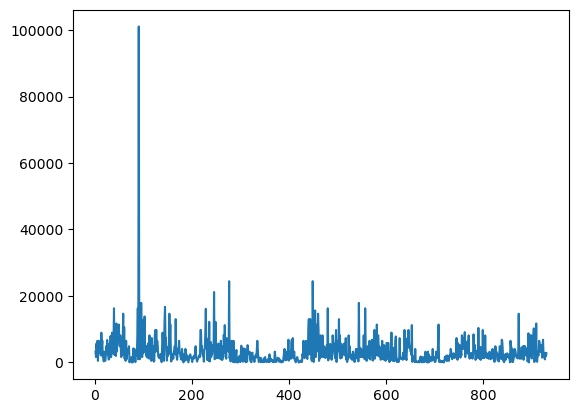

In [58]:
maize_df['Quantity of crop harvested (kg)'].plot()


<Axes: >

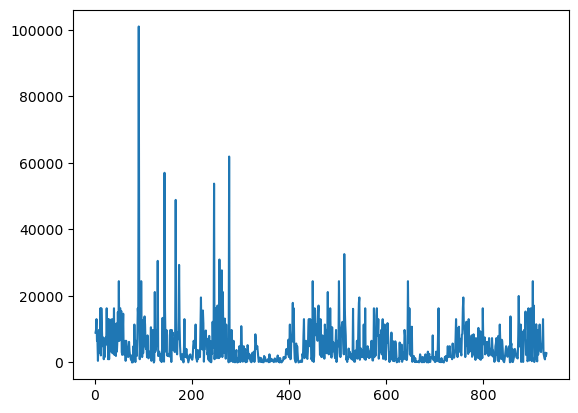

In [59]:
maize_df['Quantity of crop sold (kg)'].plot()


We can also easily combine plots

<Axes: >

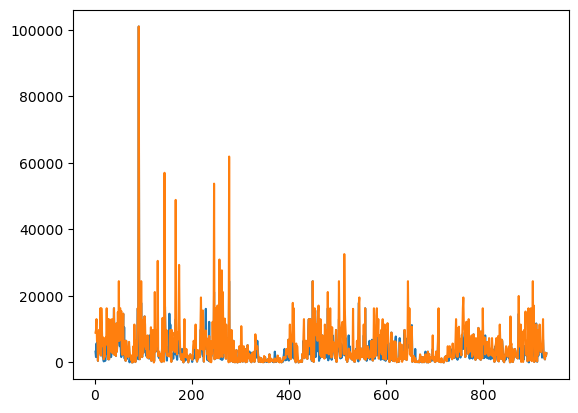

In [60]:
maize_df['Quantity of crop harvested (kg)'].plot()
maize_df['Quantity of crop sold (kg)'].plot()


As the above plots are a little messy, let's take a subset of data.  
In the example below, we take rows where the price of seeds are above a certain limit.

In [61]:
pricey_maize_df = maize_df.loc[maize_df['Price of seed planted (MMK)'] > 7500]


<Axes: >

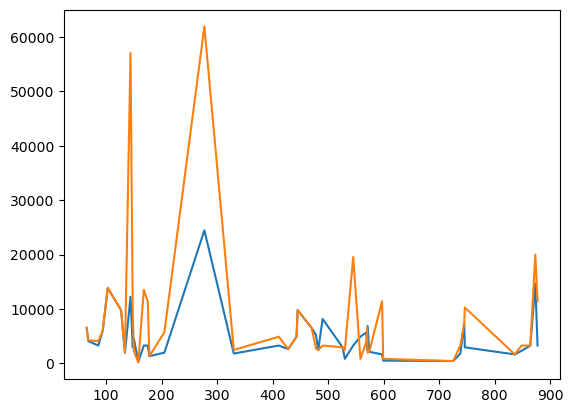

In [62]:
pricey_maize_df['Quantity of crop harvested (kg)'].plot()
pricey_maize_df['Quantity of crop sold (kg)'].plot()


In [63]:
maize_df.loc[maize_df['Quantity of crop sold (kg)'] > maize_df['Quantity of crop harvested (kg)']]


,ID,Region,Area of sample parcel (acres),Price of seed planted (MMK),Quantity of crop harvested (kg),Quantity of crop sold (kg),Total value of crop sold (MMK),Average price sold for
2,1008,Taunggyi,3.0,5600.0,3260.00,8965.000,5699051.0,1748.175153
3,1016,Taunggyi,2.0,6400.0,1630.00,9780.000,6137439.0,3765.300000
4,1023,Taunggyi,4.0,6400.0,5705.00,13040.000,3000000.0,525.854514
5,1035,Taunggyi,2.0,7000.0,2608.00,6520.000,4038488.0,1548.500000
8,1066,Taunggyi,3.5,5000.0,5705.00,7335.000,1600000.0,280.455741
...,...,...,...,...,...,...,...,...
916,100003,Mong Nai,3.0,4000.0,5705.00,11410.000,1750000.0,306.748466
921,100051,Mong Nai,1.0,5800.0,1467.00,4890.000,1050000.0,715.746421
922,100060,Mong Nai,4.0,5400.0,4890.00,8150.000,3985350.0,815.000000
923,100068,Mong Nai,9.0,4000.0,6846.00,13040.000,3120000.0,455.740578


#### 🤨 TASK
Look at, get some summary statistics for, and plot this new dataframe

## Histograms
Pandas Series also provide a `.hist` method for histograms.

<Axes: >

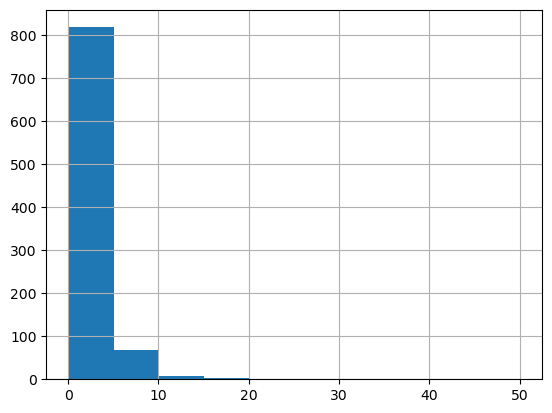

In [64]:
maize_df['Area of sample parcel  (acres)'].hist()


In [65]:
# define some smaller bins
bins_to_use = np.arange(0, 50, 1)
bins_to_use


array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49])

<Axes: >

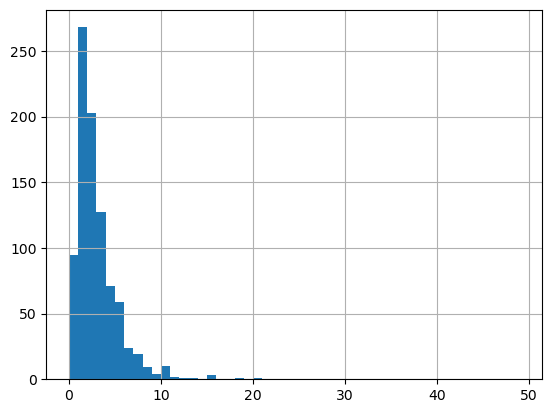

In [66]:
maize_df['Area of sample parcel  (acres)'].hist(bins=bins_to_use)


### Basics of matplotlib.pyplot (plt)
Matplotlib.pyplot (here loaded in as `plt`), open up some tools for labelling and controlling figures returned by Pandas.
This includes allowing us to set titles, labels for axes, sizing of figure, background colour etc.
For now, I will show you a very basic and well formatted way of using plt

Text(0.5, 0, 'Area size (acres)')

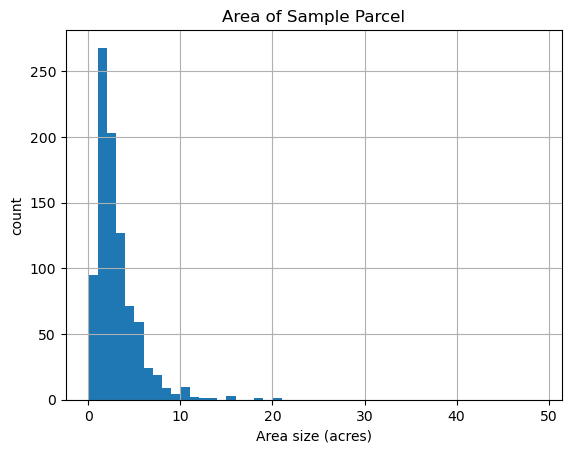

In [67]:
fig, ax = plt.subplots(1) # This line is something you will grow used to over time. It sets the figure and axes of a plot 
maize_df['Area of sample parcel  (acres)'].hist(bins=bins_to_use, ax=ax) # We pass the argument ax=ax to set the location of the plot

## Set the title, and axes labels.
ax.set_title("Area of Sample Parcel")
ax.set_ylabel("count")
ax.set_xlabel("Area size (acres)")


#### 🤨 Bigger TASK
Let's use what we have learnt to look and plot some derived information from our data.
Let's calculate the total cost of *the difference* between the crop sold and harvested.

*Advice:* make sure you use multiple cells to seperate the tasks and keep the code clean

##### Steps
1. Create a new column `Crop difference (kg)` that is the quantity of crop harvested minus the quantity of crop sold.
2. Convert this column to a difference using `abs()` (google if unsure)
3. Convert the new column from kg to grams and calculate the price (in MMK) of each gram lost (let's assume that `Price of seed planted (MMK)` is for 1g). 
4. Save this a new column e.g. `Total cost of crop difference (MMK)`
5. Plot a histogram and view data

In [106]:
maize_df.head()
maize_df["Crop difference (kg)"] = maize_df["Quantity of crop harvested (kg)"] - maize_df["Quantity of crop sold (kg)"]
maize_df["Crop difference (kg)"] = abs(maize_df["Crop difference (kg)"])
maize_df["Crop difference (g)"] = maize_df["Crop difference (kg)"] * 1000
maize_df["Total cost of crop difference (MMK)"] = maize_df["Crop difference (g)"] * maize_df["Price of seed planted (MMK)"]
maize_df["Total cost of crop difference (GBP)"] = maize_df["Total cost of crop difference (MMK)"] * 0.00038
maize_df.head()


,ID,Region,Area of sample parcel (acres),Price of seed planted (MMK),Quantity of crop harvested (kg),Quantity of crop sold (kg),Total value of crop sold (MMK),Average price sold for,Crop lost after harvest (kg),Area size group,Harvest size group,Crop difference (kg),Crop difference (g),Total cost of crop difference (MMK),Total cost of crop difference (GBP)
2,1008,Taunggyi,3.0,5600.0,3260.0,8965.0,5699051.0,1748.175153,-5705.0,Area < 1.5 acres,Harvest < 1304 kg,5705.0,5705000.0,3.194800e+10,12140240.0
3,1016,Taunggyi,2.0,6400.0,1630.0,9780.0,6137439.0,3765.300000,-8150.0,Area between 1.5 and 3 acres,Harvest between 1304 and 3260 kg,8150.0,8150000.0,5.216000e+10,19820800.0
4,1023,Taunggyi,4.0,6400.0,5705.0,13040.0,3000000.0,525.854514,-7335.0,Area > 3 acres,Harvest > 3260 kg,7335.0,7335000.0,4.694400e+10,17838720.0
5,1035,Taunggyi,2.0,7000.0,2608.0,6520.0,4038488.0,1548.500000,-3912.0,Area between 1.5 and 3 acres,Harvest between 1304 and 3260 kg,3912.0,3912000.0,2.738400e+10,10405920.0
6,1046,Taunggyi,10.5,5200.0,6520.0,6520.0,2100000.0,322.085890,0.0,Area > 3 acres,Harvest > 3260 kg,0.0,0.0,0.000000e+00,0.0


# 6. Locating items / filtering / sampling


In [69]:
maize_df.describe()


,Area of sample parcel (acres),Price of seed planted (MMK),Quantity of crop harvested (kg),Quantity of crop sold (kg),Total value of crop sold (MMK),Average price sold for
count,899.000000,899.000000,899.000000,899.000000,8.990000e+02,898.000000
mean,2.707953,4900.342375,3324.740630,5159.674900,2.705800e+06,1190.212926
std,2.751837,1896.006831,4663.717553,6910.185558,4.241353e+06,5271.635108
min,0.090000,153.374233,4.890000,0.000000,0.000000e+00,7.258021
25%,1.000000,4400.000000,1007.340000,1263.884000,5.000000e+05,350.112604
50%,2.000000,5199.999387,2119.000000,2934.000000,1.275312e+06,621.555067
75%,3.500000,6000.000000,4401.000000,7009.000000,3.200000e+06,1075.320588
max,50.000000,9600.000000,101060.000000,101060.000000,5.250000e+07,148786.400000


Looks like some of the data is incorrect as there is negative crops lost after harvest, lets investigate this

In [70]:
## Create a new column
maize_df['Crop lost after harvest (kg)'] = maize_df['Quantity of crop harvested (kg)']  - maize_df['Quantity of crop sold (kg)'] 


In [71]:
## let's look at values less than 0 kg
maize_df[maize_df['Crop lost after harvest (kg)'] < 0]


,ID,Region,Area of sample parcel (acres),Price of seed planted (MMK),Quantity of crop harvested (kg),Quantity of crop sold (kg),Total value of crop sold (MMK),Average price sold for,Crop lost after harvest (kg)
2,1008,Taunggyi,3.0,5600.0,3260.00,8965.000,5699051.0,1748.175153,-5705.000
3,1016,Taunggyi,2.0,6400.0,1630.00,9780.000,6137439.0,3765.300000,-8150.000
4,1023,Taunggyi,4.0,6400.0,5705.00,13040.000,3000000.0,525.854514,-7335.000
5,1035,Taunggyi,2.0,7000.0,2608.00,6520.000,4038488.0,1548.500000,-3912.000
8,1066,Taunggyi,3.5,5000.0,5705.00,7335.000,1600000.0,280.455741,-1630.000
...,...,...,...,...,...,...,...,...,...
916,100003,Mong Nai,3.0,4000.0,5705.00,11410.000,1750000.0,306.748466,-5705.000
921,100051,Mong Nai,1.0,5800.0,1467.00,4890.000,1050000.0,715.746421,-3423.000
922,100060,Mong Nai,4.0,5400.0,4890.00,8150.000,3985350.0,815.000000,-3260.000
923,100068,Mong Nai,9.0,4000.0,6846.00,13040.000,3120000.0,455.740578,-6194.000


This is clearly incorrect and as we imputed values with the value in the other column the difference should be 0. For these cases we can do one of two things: 
1. drop the rows
2. replace the difference with 0 

What seems more appropriate?

#### 🤨TASK

employ your prefered strategy

In [111]:
maize_df_filtered = maize_df[maize_df['Crop lost after harvest (kg)'] >= 0]

Lets look at the best performing farms, i.e. the farms which had the highest total value sold and the highest percentage crops harvested

<Axes: >

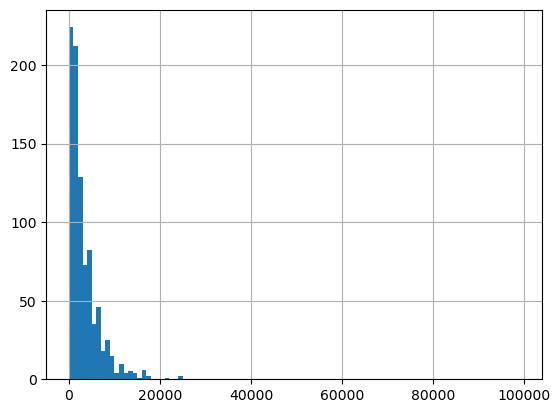

In [72]:
bins_to_use = np.arange(0, 100000, 1000)
bins_to_use
maize_df['Quantity of crop harvested (kg)'].hist(bins=bins_to_use)


In [73]:
maize_df[maize_df['Quantity of crop harvested (kg)']>10000]


,ID,Region,Area of sample parcel (acres),Price of seed planted (MMK),Quantity of crop harvested (kg),Quantity of crop sold (kg),Total value of crop sold (MMK),Average price sold for,Crop lost after harvest (kg)
40,3156,Taunggyi,8.0,600.000000,16300.00,16300.00,2150000.0,131.901840,0.0
43,3212,Taunggyi,5.0,7000.000000,10921.00,10921.00,2530000.0,231.663767,0.0
45,3275,Taunggyi,6.0,5112.474286,11736.00,11736.00,8608356.0,733.500000,0.0
50,4037,Taunggyi,5.0,5000.000000,11410.00,24450.00,10500000.0,920.245399,-13040.0
59,4133,Taunggyi,7.0,7000.000000,14670.00,14670.00,12000000.0,817.995910,0.0
61,4152,Taunggyi,7.0,6600.000000,10595.00,4890.00,21500000.0,2029.259084,5705.0
89,9073,Taunggyi,7.0,2556.237219,16300.00,16300.00,10900000.0,668.711656,0.0
91,9111,Taunggyi,50.0,5000.000000,101060.00,101060.00,27900000.0,276.073620,0.0
96,10044,Taunggyi,15.0,7200.000000,17930.00,24450.00,7500000.0,418.293363,-6520.0
99,10086,Taunggyi,8.5,5200.000000,12714.00,12714.00,10200000.0,802.265219,0.0


<Axes: >

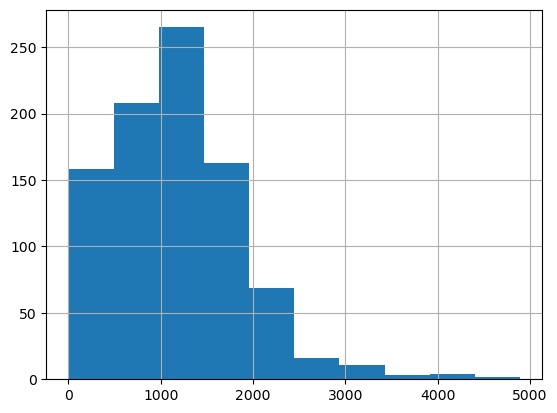

In [113]:
maize_df["Yield per acre (kg / acre)"] = maize_df["Quantity of crop harvested (kg)"] / maize_df["Area of sample parcel  (acres)"]
maize_df["Yield per acre (kg / acre)"].hist()

In [114]:
maize_df[maize_df["Yield per acre (kg / acre)"] > 4500]

,ID,Region,Area of sample parcel (acres),Price of seed planted (MMK),Quantity of crop harvested (kg),Quantity of crop sold (kg),Total value of crop sold (MMK),Average price sold for,Crop lost after harvest (kg),Area size group,Harvest size group,Crop difference (kg),Crop difference (g),Total cost of crop difference (MMK),Total cost of crop difference (GBP),Yield per acre (kg / acre)
562,55078,Lawksawk,1.0,7200.0,4890.0,4890.0,2391210.0,489.000000,0.0,Area < 1.5 acres,Harvest > 3260 kg,0.0,0.0,0.000000e+00,0.0,4890.0
571,56043,Lawksawk,1.5,7600.0,6846.0,1956.0,450000.0,65.731814,4890.0,Area < 1.5 acres,Harvest > 3260 kg,4890.0,4890000.0,3.716400e+10,14122320.0,4564.0


#### 🤨TASK
*Advice:* make sure you use multiple cells to seperate the tasks and keep the code clean

Make new column with percentage of crops lost 

#### 🤨TASK

Find the well performing farms with a low percentage (10%) of crops lost

In [74]:

???

Object `?` not found.


#### Sampling
For many statistical applications you may need to use sampling when you have uneven categories of things. Pandas provides a very simple solution to sampling with the `.sample()` method...

In [75]:
maize_df.sample(10)

,ID,Region,Area of sample parcel (acres),Price of seed planted (MMK),Quantity of crop harvested (kg),Quantity of crop sold (kg),Total value of crop sold (MMK),Average price sold for,Crop lost after harvest (kg)
432,43090,Lawksawk,1.0,5000.000000,1304.0,1304.0,531380.0,407.500000,0.0
814,87046,Mong Nai,1.0,5000.000000,1304.0,4075.0,1992675.0,1528.125000,-2771.0
75,7008,Taunggyi,0.8,5200.000000,815.0,815.0,371966.0,456.400000,0.0
300,26026,Hsi Hseng,1.0,392.638133,130.4,130.4,63765.6,489.000000,0.0
589,58095,Lawksawk,1.0,5000.000000,815.0,3260.0,1328450.0,1630.000000,-2445.0
845,92048,"Shan (Pyine), Myanmar",1.5,6000.000000,2445.0,2445.0,525000.0,214.723926,0.0
71,5114,Taunggyi,3.0,5500.000000,4890.0,6194.0,4088969.0,836.189980,-1304.0
793,85127,Mong Nai,1.0,7000.000000,978.0,978.0,637656.0,652.000000,0.0
340,30085,Hsi Hseng,0.7,4600.000000,1467.0,1467.0,836923.5,570.500000,0.0
10,1083,Taunggyi,3.5,1533.742331,3749.0,9780.0,2338072.0,623.652174,-6031.0


# 7. Grouping / pivoting + plotting
Finally, we will briefly cover more advanced pandas methods for handling and grouping data. 
Firstly `.groupby()` which will allow us to group categorical variables i.e. such as Region

In [76]:
# Let's look at the regional mean values
maize_df.groupby('Region').mean()

,ID,Area of sample parcel (acres),Price of seed planted (MMK),Quantity of crop harvested (kg),Quantity of crop sold (kg),Total value of crop sold (MMK),Average price sold for,Crop lost after harvest (kg)
Region,,,,,,,,
Hsi Hseng,25669.641667,2.569667,3855.998481,2729.023497,4518.488285,2.766651e+06,897.444808,-1789.464788
Lawksawk,50418.411765,3.584412,5509.066834,4107.989712,6141.075606,3.273240e+06,1138.794031,-2033.085894
Mong Nai,90066.132867,2.723636,5479.101062,3412.748923,5882.525615,2.963124e+06,2251.156979,-2469.776692
Pekhon,68152.088235,2.191765,4812.508873,3048.387647,3894.644412,2.262745e+06,882.317384,-846.256765
Pindaya,36494.046875,1.840625,4437.689038,1447.584631,2375.341994,1.423648e+06,1024.594983,-927.757362
Pinlaung,69342.142857,1.530238,5893.527318,2459.592381,3386.711429,1.726153e+06,981.070480,-927.119048
"Shan (Pyine), Myanmar",49791.233333,2.386778,4694.172041,2682.542476,4004.526605,2.021649e+06,813.266051,-1321.984129
Taunggyi,25957.889831,2.779068,4682.178527,3957.861696,6034.135819,2.956969e+06,1002.704777,-2076.274122


#### 🤨TASK
In a new cell below, save a new variable `regional_means` which is a groupby of the Regional means and then make a barplot of "Price of seed planted (MMK)". Which region planted the most expensive seeds on average?

Okay, so we've looked at the regional mean, what if we wanted to get a sum of a column by region? 

In [77]:
# Take a sum of only the total crop sold values (we can use the .agg function to only get this value)
crops_sold_by_region = maize_df.groupby('Region').agg({'Total value of crop sold (MMK)':'sum'})

Note: if you wanted the sum of one column and the mean of another the syntax would be like:  
`df.groupby('col').agg({'col1':'sum', 'col2':'mean'})`

Let's plot this data

In [78]:
crops_sold_by_region.head()

,Total value of crop sold (MMK)
Region,
Hsi Hseng,3.319982e+08
Lawksawk,5.564508e+08
Mong Nai,4.237268e+08
Pekhon,7.693334e+07
Pindaya,9.111346e+07


<Axes: xlabel='Region'>

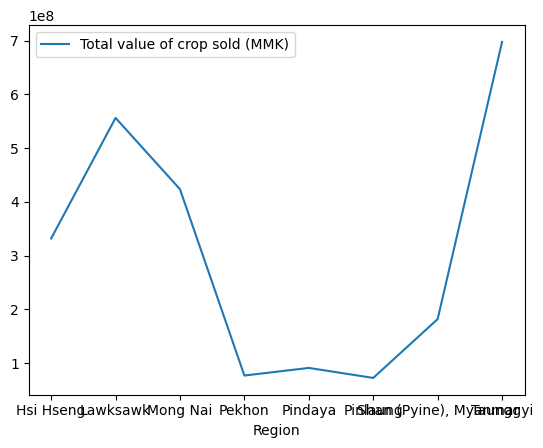

In [79]:
crops_sold_by_region.plot()


Let's use matplotlib.pyplot (plt) to clean up and make this figure a little nicer...

<Axes: xlabel='Region'>

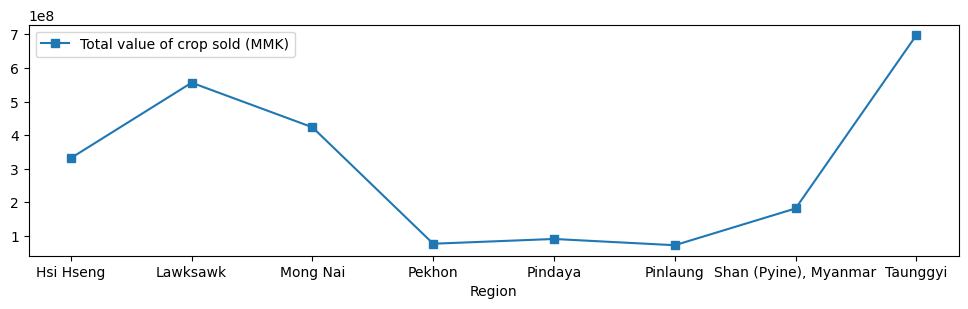

In [80]:
fig, ax = plt.subplots(1, figsize=(12, 3))
crops_sold_by_region.plot(marker='s', ax=ax)


#### 🤨TASK
In the cell above, add a title, y and x label.

*Remember:* Google may help

**Further Tasks** Set the font size of the title and axes labels. 
Also look at changing the markers to circles and the color of line to black...


### Pivoting
Another form of data handling that pandas opens up is pivoting with `.pivot()`.

Firstly, let's get something worthwhile pivoting the data on. Let's look at the influence of groups of area size to groups of harvest amount i.e. can we prove with this data that larger plot sizes mean more harvest in kg?

Let's take the 33rd and 66th percentile as cut off points for our groups. We use pandas inbuilt function `.quantile` to get these values...

In [81]:
## Let's look at the 33rd and 66th percentile values for area sizes
maize_df['Area of sample parcel  (acres)'].quantile([0.33, 0.66])

0.33    1.5
0.66    3.0
Name: Area of sample parcel  (acres), dtype: float64

Next, let's define a simple function that we can `.apply` to our dataset to label the data based on these quantile values of 1.5 and 3.0

In [82]:
def label_data_based_on_area(row):
    # Simple function to label data in Area of sample parcel column
    if row['Area of sample parcel  (acres)'] > 3:
        return "Area > 3 acres"
    elif row['Area of sample parcel  (acres)'] > 1.5 and row['Area of sample parcel  (acres)'] < 3:
        return "Area between 1.5 and 3 acres"
    else:
        return "Area < 1.5 acres"


In [83]:
# Create new data column
maize_df['Area size group'] = maize_df.apply(label_data_based_on_area, axis=1)

In [84]:
maize_df['Area size group'] 

2                  Area < 1.5 acres
3      Area between 1.5 and 3 acres
4                    Area > 3 acres
5      Area between 1.5 and 3 acres
6                    Area > 3 acres
                   ...             
926                Area < 1.5 acres
927    Area between 1.5 and 3 acres
928                Area < 1.5 acres
929                Area < 1.5 acres
930    Area between 1.5 and 3 acres
Name: Area size group, Length: 899, dtype: object

These labels look good, let's now do the same for the quantity of crop harvested...

In [85]:
## Let's look at the 33rd and 66th percentile values of crop harvested sizes
maize_df['Quantity of crop harvested (kg)'].quantile([0.33, 0.66])

0.33    1304.0
0.66    3260.0
Name: Quantity of crop harvested (kg), dtype: float64

And define another very similar function.
For more efficient code, you want to avoid very similar functions (i.e. functions that share a large % of code), but for this example it is okay...

In [86]:
def label_data_based_on_crop_harvested(row):
    # Another simple function to label data.
    if row['Quantity of crop harvested (kg)'] > 3260:
        return "Harvest > 3260 kg"
    elif row['Quantity of crop harvested (kg)'] > 1304 and row['Quantity of crop harvested (kg)'] < 3260:
        return "Harvest between 1304 and 3260 kg"
    else:
        return "Harvest < 1304 kg"


In [87]:
# Apply this function and create a new column
maize_df['Harvest size group'] = maize_df.apply(label_data_based_on_crop_harvested, axis=1)

In [88]:
maize_df['Harvest size group'] 

2                     Harvest < 1304 kg
3      Harvest between 1304 and 3260 kg
4                     Harvest > 3260 kg
5      Harvest between 1304 and 3260 kg
6                     Harvest > 3260 kg
                     ...               
926                   Harvest < 1304 kg
927                   Harvest < 1304 kg
928    Harvest between 1304 and 3260 kg
929    Harvest between 1304 and 3260 kg
930    Harvest between 1304 and 3260 kg
Name: Harvest size group, Length: 899, dtype: object

Now, let's pivot based on these two new columns and see what we get 

In [89]:
maize_df_harvest_area_pivot = maize_df.pivot(index='ID', columns='Harvest size group', values='Area size group')

In [90]:
# This is a breakdown of Harvest size to Area size
maize_df_harvest_area_pivot

Harvest size group,Harvest < 1304 kg,Harvest > 3260 kg,Harvest between 1304 and 3260 kg
ID,,,
1008,Area < 1.5 acres,NaN,NaN
1016,NaN,NaN,Area between 1.5 and 3 acres
1023,NaN,Area > 3 acres,NaN
1035,NaN,NaN,Area between 1.5 and 3 acres
1046,NaN,Area > 3 acres,NaN
...,...,...,...
100096,Area < 1.5 acres,NaN,NaN
100102,Area between 1.5 and 3 acres,NaN,NaN
100109,NaN,NaN,Area < 1.5 acres


Let's count the values of each column with `.value_counts()`

In [91]:
maize_df_harvest_area_pivot['Harvest < 1304 kg'].value_counts()

Harvest < 1304 kg
Area < 1.5 acres                259
Area between 1.5 and 3 acres     65
Area > 3 acres                   23
Name: count, dtype: int64

In [92]:
maize_df_harvest_area_pivot['Harvest > 3260 kg'].value_counts()

Harvest > 3260 kg
Area > 3 acres                  184
Area < 1.5 acres                 53
Area between 1.5 and 3 acres     41
Name: count, dtype: int64

#### 🤨TASK
Have a play around and determine whether you could say that one size of area is more efficient for quantity of harvest than the others based only on the labels we have created here. 

*Hint:* Perhaps use .sample to create equally sized subsets, as these three categories have different amounts of values

**FURTHER TASK** Create a visualisation to show this.

In [93]:
???

Object `?` not found.


## Thanks!